# Spark Project

Spark project

author(s): Hao Ye UID: 23376; Pierre-Louis Landouzi

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import functions
from pyspark.sql.functions import udf, isnan, when, count, col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [3]:
spark_application_name = "Spark_Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 11:12:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/17 11:12:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
stocks_path = 'stocks_data/MICROSOFT.csv'

### Read Data function

In [5]:
def get_data(path, schema, header=True, delimiter=';'):
    """Lire les données à partir d'un path.

    Parameters
    ----------
    path : string
        Le chemin du fichier
    schema : StructType
        Le schema appliqué sur le dataframe
    header: bool
        Le boolean qui indique l'utilisation de la première ligne comme noms de colonnes. True par défaut
    delimiter: 
        Définit un séparateur pour chaque champ et chaque valeur. ; par défaut
    Returns
    -------
    DataFrame
        Le DataFrame du fichier
    """
    
    extension = path.split('.')[-1]
    if (extension == "csv"):
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    elif (extension == 'json'):
        df = spark.read.json(path, schema)
    else:
        # join all csv in a folder
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    return df


In [6]:
# Define schema
stocksColumns = [StructField("Date",TimestampType()), StructField("High",DoubleType()), 
              StructField("Low",DoubleType()), StructField("Open",DoubleType()),
              StructField("Close",DoubleType()), StructField("Volume", DoubleType()), 
              StructField("Adj Close",DoubleType()), StructField("company_name", StringType())]

stocksSchema = StructType(stocksColumns)


df = get_data(stocks_path, stocksSchema, delimiter=',')
df.show()

+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT|
|2017-01-06 00:00:00|63.150001525878906|62.040000915527344| 62.29999923706055| 62.84000015258789|1.99229E7|58.917015075683594|   MICROSOFT|
|2017-01-09 00:00:00

In [6]:
def show_first_rows(df):
    """Afficher les 40 permières lignes d'un dataframe.

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df.show(40)

In [7]:
def show_last_rows(df):
    """Afficher les 40 dernières lignes d'un dataframe.

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    spark.createDataFrame(df.tail(40)).show()

In [8]:
def get_num_rows(df):
    """Afficher le nombres de lignes d'un dataframe.

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    print('Number of rows: ' + str(df.count()))

In [9]:
def days_to_period(nb_days):
    if (nb_days > 365):
        return 'year'
    elif (nb_days > 28):
        return 'month'
    elif (nb_days > 7):
        return "week"
    else:
        return 'day'

def get_period(df):
    """Afficher la période d'un dataframe

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df = df.select("Date")
    # Create a by 1 shift column 
    my_window = Window.partitionBy().orderBy("Date")
    # Assign on prev_date column
    df = df.withColumn("prev_date", functions.lag(df.Date).over(my_window))
    # Compute diff between Date column and prev_date column and save on delta column
    df = df.withColumn("delta", functions.when(functions.isnull(df['Date'].cast("long") - df['prev_date'].cast('long')), 0)
                              .otherwise(df['Date'].cast('long') - df['prev_date'].cast('long')))
    # Compute diff in days
    df = df.withColumn("delta_days" , df['delta']/(24*3600))
    # Transform function to udf, just like .apply in pandas
    udf_days_to_period = udf(lambda x:days_to_period(x),StringType())
    
    # Compute the period according to days
    df = df.withColumn("period", udf_days_to_period(df['delta_days']))
    
    df = df.groupBy("period").count()
    df = df.sort(df["count"].desc())
    X = df.collect()[0][0]
    print('The period is a ' + str(X) + ' period')

In [10]:
get_period(df)

22/05/12 10:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/12 10:21:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


The period is a day period


In [11]:
def get_stats(df):
    """Afficher les statistiques de base d'un dataframe

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df.describe().show()

In [12]:
get_stats(df)

+-------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+
|summary|              High|               Low|              Open|             Close|              Volume|         Adj Close|company_name|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+
|  count|               987|               987|               987|               987|                 987|               987|         987|
|   mean|123.52858665334901|121.02308006634466|122.32611970601957|122.34503256924367|2.9104952561296858E7|119.77032003045203|        null|
| stddev| 46.40416482581066|45.038031013567725| 45.73307377448831| 45.74600811823214|1.3627194702253582E7| 46.76978863281242|        null|
|    min| 62.65999984741211| 61.95000076293945|62.189998626708984| 62.29999923706055|           6486678.0| 58.41072463989258|   MICROSOFT|
|    max|232.86000061035156

In [13]:
def get_na(df):
    """Afficher le nombre de valeur manquante pour chaque colonne

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    # Cast timestamp to long for check null
    df2 = df.withColumn("Date_long", df['Date'].cast('long'))
    df2 = df2.drop(df2['Date'])
    df2 = df2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df2.columns])
    df2.show()

In [14]:
get_na(df)

+----+---+----+-----+------+---------+------------+---------+
|High|Low|Open|Close|Volume|Adj Close|company_name|Date_long|
+----+---+----+-----+------+---------+------------+---------+
|   0|  0|   0|    0|     0|        0|           0|        0|
+----+---+----+-----+------+---------+------------+---------+



In [15]:
def plot_corr(df):
    """Dessiner la matrice de corrélation

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df = df.drop(*('Date', 'company_name'))
    columns = df.columns
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
    
    matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
    corrmatrix = matrix.toArray().tolist()

    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+columns)
    ax.set_yticklabels(['']+columns)
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

22/05/12 10:21:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/12 10:21:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_9840/2972400243.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_9840/2972400243.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


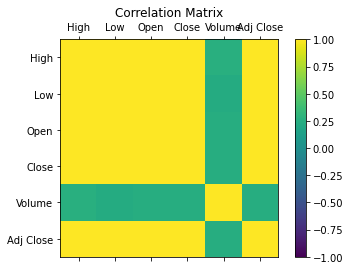

In [16]:
plot_corr(df)

In [30]:
def get_period_avg(df, period='week'):
    """Avoir la moyenne d'une period

    Parameters
    ----------
    df : DataFrame
    
    period : string
        la period pour la moyenne, par défaut week
    Returns
    -------
        DataFrame
    """
    
    df_pd = df.toPandas()
    if (period == 'week'):
        df_pd['Date'] = pd.to_datetime(df_pd['Date']) - pd.to_timedelta(7, unit='d')
        df_pd = df_pd.groupby(pd.Grouper(key='Date', freq='W-MON'))[['Open', 'Close']].mean().reset_index()
        df_pd.columns = ['Date', 'weekly_avg_open', 'weekly_avg_close']
    elif (period == 'month'):
        df_pd = df_pd.groupby(pd.Grouper(key='Date', freq='M'))[['Open', 'Close']].mean().reset_index()
        df_pd.columns = ['Date', 'monthly_avg_open', 'monthly_avg_close']
    elif (period == 'year'):
        df_pd = df_pd.groupby(pd.Grouper(key='Date', freq='Y'))[['Open', 'Close']].mean().reset_index()
        df_pd.columns = ['Date', 'annualy_avg_open', 'annualy_avg_close']
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
        
    # Maybe plot a graph ?
    return spark.createDataFrame(df_pd)

In [34]:
df_pd = get_period_avg(df, 'year')
df_pd.show()

+-------------------+------------------+------------------+
|               Date|  annualy_avg_open| annualy_avg_close|
+-------------------+------------------+------------------+
|2017-12-31 00:00:00| 71.95430287516925| 71.98402421502954|
|2018-12-31 00:00:00|101.12235092831799|101.03398411967365|
|2019-12-31 00:00:00|130.33904787093874|130.38202400813026|
|2020-12-31 00:00:00|190.76480678836674| 190.8616180419922|
+-------------------+------------------+------------------+



In [87]:
def get_evolution(df, period='day'):
    """Avoir l'évolution du prix 

    Parameters
    ----------
    df : DataFrame
    
    period : string
        l'échelle de l'évolution, par défaut week
    Returns
    -------
        DataFrame
    """
    w = Window.partitionBy().orderBy("Date")
    if (period == 'day'): 
        df_prev = df.withColumn('prev_high', functions.lag(df['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df['Close']).over(w))
    
    elif (period == 'month'):
        df_pd = df.toPandas()
        df_pd = df_pd.groupby(pd.Grouper(key='Date', freq='M'))[['High', 'Low', 'Open', 'Close']].sum().reset_index()
        df_group_by_month = spark.createDataFrame(df_pd)
        
        df_group_by_month.printSchema()
        df_prev = df_group_by_month.withColumn('prev_high', functions.lag(df_group_by_month['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df_group_by_month['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df_group_by_month['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df_group_by_month['Close']).over(w))
    else:
        raise ValueError("Incorrect period format, expected day, month")
        
    result_df = df_prev.withColumn('delta_high', df_prev['High'] - df_prev['prev_high']) \
                   .withColumn('delta_low', df_prev['Low'] - df_prev['prev_low']) \
                   .withColumn('delta_open', df_prev['Open'] - df_prev['prev_open']) \
                   .withColumn('delta_close', df_prev['Close'] - df_prev['prev_close']) \
                   .select('Date', 'delta_high', 'delta_low', 'delta_open', 'delta_close')
    
    return result_df

In [88]:
df_evol = get_evolution(df, 'month')
df_evol.show()

root
 |-- Date: timestamp (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Close: double (nullable = true)

+-------------------+-------------------+-------------------+-------------------+-------------------+
|               Date|         delta_high|          delta_low|         delta_open|        delta_close|
+-------------------+-------------------+-------------------+-------------------+-------------------+
|2017-01-31 00:00:00|               null|               null|               null|               null|
|2017-02-28 00:00:00| -47.19999694824219| -43.17999267578125| -45.14999771118164|-45.679988861083984|
|2017-03-31 00:00:00|  275.0299873352051|  270.3399963378906| 271.02002334594727|  273.1900100708008|
|2017-04-30 00:00:00|-234.58000946044922|-231.86999130249023|-231.04001998901367|-234.09000396728516|
|2017-05-31 00:00:00|   258.760009765625| 255.37997436523438| 255.68000030517578|  258.9199981689

22/05/12 12:16:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/12 12:16:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/12 12:16:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [9]:

df.show()

+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT|
|2017-01-06 00:00:00|63.150001525878906|62.040000915527344| 62.29999923706055| 62.84000015258789|1.99229E7|58.917015075683594|   MICROSOFT|
|2017-01-09 00:00:00

In [63]:
from pyspark.sql.functions import expr

def dailyReturn(df):
    return df.select(col("company_name"), col("Date"), expr("(Close - Open) as dailyReturn"))

In [64]:
dailyReturn(df).show()

+------------+-------------------+--------------------+
|company_name|               Date|         dailyReturn|
+------------+-------------------+--------------------+
|   MICROSOFT|2017-01-03 00:00:00|-0.20999908447265625|
|   MICROSOFT|2017-01-04 00:00:00|-0.18000030517578125|
|   MICROSOFT|2017-01-05 00:00:00|  0.1100006103515625|
|   MICROSOFT|2017-01-06 00:00:00|  0.5400009155273438|
|   MICROSOFT|2017-01-09 00:00:00|-0.11999893188476562|
|   MICROSOFT|2017-01-10 00:00:00| -0.1100006103515625|
|   MICROSOFT|2017-01-11 00:00:00|  0.5799980163574219|
|   MICROSOFT|2017-01-12 00:00:00| -0.4500007629394531|
|   MICROSOFT|2017-01-13 00:00:00|  0.0800018310546875|
|   MICROSOFT|2017-01-17 00:00:00|-0.15000152587890625|
|   MICROSOFT|2017-01-18 00:00:00| -0.1699981689453125|
|   MICROSOFT|2017-01-19 00:00:00|    0.05999755859375|
|   MICROSOFT|2017-01-20 00:00:00| 0.07000350952148438|
|   MICROSOFT|2017-01-23 00:00:00|  0.2599983215332031|
|   MICROSOFT|2017-01-24 00:00:00| 0.31999969482

In [58]:
from pyspark.sql.functions import desc, max

def bestDailyReturn(df):
    return df.select(col("company_name"), expr("(Close - Open) as dailyReturn"))\
        .groupBy(col('company_name'))\
        .agg(max('dailyReturn'))

In [59]:
bestDailyReturn(df).show()

+------------+------------------+
|company_name|  max(dailyReturn)|
+------------+------------------+
|   MICROSOFT|11.330001831054688|
+------------+------------------+



In [139]:
from pyspark.sql.functions import date_sub, next_day

def averageDailyReturnByWeek(df):
    return dailyReturn(df)\
    .withColumn("Date",date_sub(next_day(col("Date"),"sunday"),7))\
    .groupBy("company_name", "Date").max("dailyReturn")

def averageDailyReturnByMonth(df):
    return dailyReturn(df)\
    .withColumn("Date",date_format(col("Date"),"yyyy-MM"))\
    .groupBy("company_name", "Date").max("dailyReturn")

def averageDailyReturnByYear(df):
    return dailyReturn(df)\
    .withColumn("Date",date_format(col("Date"),"yyyy"))\
    .groupBy("company_name", "Date").max("dailyReturn")

averageDailyReturnByWeek(df).show()
averageDailyReturnByMonth(df).show()
averageDailyReturnByYear(df).show()

+------------+----------+-------------------+
|company_name|      Date|   max(dailyReturn)|
+------------+----------+-------------------+
|   MICROSOFT|2017-01-15|0.07000350952148438|
|   MICROSOFT|2020-02-02|   3.95001220703125|
|   MICROSOFT|2020-03-15|   6.57000732421875|
|   MICROSOFT|2017-06-18| 1.1200027465820312|
|   MICROSOFT|2019-11-10|  1.040008544921875|
|   MICROSOFT|2019-09-22| 1.8600006103515625|
|   MICROSOFT|2017-07-09| 0.5400009155273438|
|   MICROSOFT|2018-09-09|  2.339996337890625|
|   MICROSOFT|2020-08-02|  5.019989013671875|
|   MICROSOFT|2017-08-20| 0.8100051879882812|
|   MICROSOFT|2018-02-04|   4.44000244140625|
|   MICROSOFT|2018-05-27| 1.5100021362304688|
|   MICROSOFT|2018-09-30| 0.8600006103515625|
|   MICROSOFT|2018-02-25|  1.470001220703125|
|   MICROSOFT|2018-11-11| 2.2900009155273438|
|   MICROSOFT|2019-02-10|               0.75|
|   MICROSOFT|2018-10-14| 1.4599990844726562|
|   MICROSOFT|2017-08-27|                1.0|
|   MICROSOFT|2018-07-08| 1.420005

In [112]:
averageDailyReturn(df).show()

+------------+----------+--------------------+
|company_name|      Date|         dailyReturn|
+------------+----------+--------------------+
|   MICROSOFT|2017-01-03|-0.20999908447265625|
|   MICROSOFT|2017-01-04|-0.18000030517578125|
|   MICROSOFT|2017-01-05|  0.1100006103515625|
|   MICROSOFT|2017-01-06|  0.5400009155273438|
|   MICROSOFT|2017-01-09|-0.11999893188476562|
|   MICROSOFT|2017-01-10| -0.1100006103515625|
|   MICROSOFT|2017-01-11|  0.5799980163574219|
|   MICROSOFT|2017-01-12| -0.4500007629394531|
|   MICROSOFT|2017-01-13|  0.0800018310546875|
|   MICROSOFT|2017-01-17|-0.15000152587890625|
|   MICROSOFT|2017-01-18| -0.1699981689453125|
|   MICROSOFT|2017-01-19|    0.05999755859375|
|   MICROSOFT|2017-01-20| 0.07000350952148438|
|   MICROSOFT|2017-01-23|  0.2599983215332031|
|   MICROSOFT|2017-01-24| 0.31999969482421875|
|   MICROSOFT|2017-01-25| -0.2700004577636719|
|   MICROSOFT|2017-01-26|   0.149993896484375|
|   MICROSOFT|2017-01-27|  0.3899993896484375|
|   MICROSOFT